In [1]:
import torch
from bbox_utils import *
import torch
from torch import nn
import torch.optim as optimizer
import torch.nn.functional as f
from pathlib import Path
import os
import bbox_utils
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d, Dropout, MaxPool2d, BatchNorm1d, BatchNorm2d
import pandas as pd
import json
import visualization
import model
import torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from bbox_aug import *
from data_aug import *

c:\Users\Jensm\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Target vector length 441


In [2]:
new_size = model.IMAGE_SIZE[0]
ratio = int(512/new_size)

def resize_bbox_rowwise(row):
    return np.array(bbox_utils.transformsBbox(row['bbox'], ratio), dtype='float64')

def resize_im_rowwise(row):
    return bbox_utils.transformsImg(row['path'], new_size)


In [3]:
#Loading the model

dir_root = os.path.abspath('')
model_dir = Path(dir_root, '../data\model/2022-12-10 13_38_46/model/epoch_59.pth') # replace here the name of the model you want to use

In [4]:
train_imgs = Path(dir_root, '../data/train')
test_imgs = Path(dir_root, '../data/test')
annot_dir = Path(dir_root, '../data/annot/rareplanes.json')

In [5]:
with open(annot_dir) as json_data:
    data = json.load(json_data)

annot_train = pd.DataFrame(data['categories'])
annot_train.drop(['loc_id', 'cat_id', 'location', 'role', 'role_id', 'is_plane', 'num_engines', 'propulsion', 'canards', 'num_tail_fins', 'wing_position', 'wing_type',
                'length', 'wingspan', 'area', 'faa_wingspan_class', 'Public_Train', 'Public_Test', 'partialDec', 'truncated', 'new_area', 'area_pixels', 'id'], axis=1, inplace=True)
annot_train.rename(columns={"image_fname": "name"}, inplace=True)

annot_train = annot_train.groupby(['image_id']).agg(
    tuple).applymap(np.array).reset_index()

annot_train.drop(annot_train.index.to_list()[100:], axis=0, inplace=True)

annot_train['path'] = annot_train.apply(
    lambda row: str(train_imgs) + "/"+row['name'][0], axis=1)
annot_train.drop(['name', 'image_id'], axis=1, inplace=True)

In [6]:
annot_train['image'] = annot_train.apply(resize_im_rowwise, axis=1)
annot_train['bbox'] = annot_train.apply(resize_bbox_rowwise, axis=1)
annot_train.head()

,bbox,path,image
0,"[[0.0, 227.0, 61.0, 255.0]]",c:\Users\Jensm\OneDrive - Danmarks Tekniske Un...,"[[[53, 45, 38], [54, 45, 39], [52, 44, 38], [5..."
1,"[[123.0, 118.0, 147.0, 133.0], [127.0, 0.0, 14...",c:\Users\Jensm\OneDrive - Danmarks Tekniske Un...,"[[[25, 21, 22], [24, 20, 20], [26, 22, 21], [2..."
2,"[[16.0, 232.0, 78.0, 255.0]]",c:\Users\Jensm\OneDrive - Danmarks Tekniske Un...,"[[[11, 14, 9], [15, 19, 12], [15, 18, 12], [16..."
3,"[[53.0, 11.0, 85.0, 38.0], [150.0, 85.0, 172.0...",c:\Users\Jensm\OneDrive - Danmarks Tekniske Un...,"[[[101, 86, 69], [99, 86, 70], [37, 32, 27], [..."
4,"[[229.0, 118.0, 242.0, 129.0], [246.0, 97.0, 2...",c:\Users\Jensm\OneDrive - Danmarks Tekniske Un...,"[[[64, 52, 45], [64, 52, 46], [71, 58, 51], [6..."


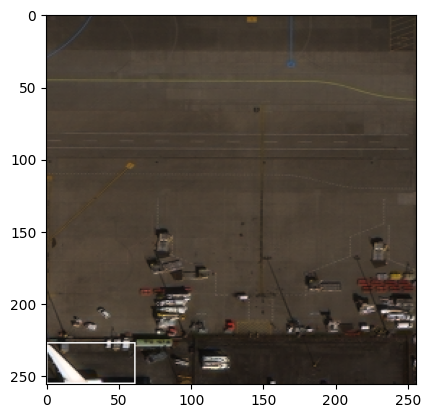

In [7]:
image_idx = 0

plotted_img = draw_rect(annot_train['image'][image_idx], annot_train['bbox'][image_idx])
plt.imshow(plotted_img)
plt.show()

In [8]:
aircraft_model = model.AircraftModel()
aircraft_model.load_weights(model_dir)
aircraft_model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\Jensm\\OneDrive - Danmarks Tekniske Universitet\\9. semester\\02456 - Deep Learning\\Project\\src\\..\\data\\model\\2022-12-10 13_38_46\\model\\epoch_59.pth'

In [ ]:
import training_utilities
import random
import importlib
import numpy as np
from pprint import pprint

importlib.reload(visualization)


THRESHHOLD = 0.5
mAP_treshhold = 0
inputs = torch.from_numpy(np.array([annot_train['image'][image_idx]], dtype = "float64")/255)
inputs = torch.permute(inputs, (0, 3, 1, 2))

output = aircraft_model(inputs)
targets = training_utilities.calculate_target_vector(annot_train['bbox'][image_idx])

###

predicted_bboxs = model.np_bboxs #[output[0] >= mAP_treshhold]
labels_predicted_bboxs = np.zeros(len(predicted_bboxs))

real_bboxs = annot_train['bbox']
labels_real_bboxs = np.zeros(len(real_bboxs))

###


print("Real bbox: ", real_bboxs)
#print("Predicted bbox: ", predicted_bboxs.dtype)

visualization.display_bbox_target_vector(annot_train['image'][image_idx], output[0], model.np_bboxs, THRESHHOLD)

#boxes = torch.from_numpy(predicted_bboxs)
#print("boxes", boxes)

# pred = []
# targ = []
# #print(torch.tensor(labels_predicted_bboxs))
# for i in range(len(annot_train['image'])):

#     inputs = torch.from_numpy(np.array([annot_train['image'][i]], dtype = "float64")/255)
#     inputs = torch.permute(inputs, (0, 3, 1, 2))

#     output = aircraft_model(inputs)

#     pred.append(
#                 dict(
#                     boxes = torch.from_numpy(predicted_bboxs),
#                     scores= output.flatten(),
#                     labels=torch.tensor(labels_predicted_bboxs),
#                     )
#                 )   

#     targ.append(
#                 dict(
#                     boxes = torch.tensor(real_bboxs[i]),
#                     labels=torch.tensor(np.zeros(len(real_bboxs[i]))),
#                     )
#                 )   


# metric = MeanAveragePrecision()
# metric.update(pred, targ)

# print(metric.compute())

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 4096])

In [18]:
import torch
import model

# data for yolo
with open(annot_dir) as json_data:
    data = json.load(json_data)

yolo_data = pd.DataFrame(data['categories'])
yolo_data.drop(['loc_id', 'cat_id', 'location', 'role', 'role_id', 'is_plane', 'num_engines', 'propulsion', 'canards', 'num_tail_fins', 'wing_position', 'wing_type',
                'length', 'wingspan', 'area', 'faa_wingspan_class', 'Public_Train', 'Public_Test', 'partialDec', 'truncated', 'new_area', 'area_pixels', 'id'], axis=1, inplace=True)
yolo_data.rename(columns={"image_fname": "name"}, inplace=True)

yolo_data = yolo_data.groupby(['image_id']).agg(
    tuple).applymap(np.array).reset_index()

yolo_data.drop(yolo_data.index.to_list()[100:], axis=0, inplace=True)

yolo_data['path'] = yolo_data.apply(
    lambda row: str(train_imgs) + "/"+row['name'][0], axis=1)
yolo_data.drop(['name', 'image_id'], axis=1, inplace=True)

# Model
yolov5s_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)


predicted_bboxs = model.np_bboxs #[output[0] >= mAP_treshhold]
labels_predicted_bboxs = np.zeros(len(predicted_bboxs))

pred = []
targ = []
#print(torch.tensor(labels_predicted_bboxs))
for i in range(len(yolo_data['path'])):
    # inputs = torch.permute(inputs, (0, 3, 1, 2))
    img_path = yolo_data['path'][i]
    # Inference
    results = yolov5s_model(img_path)

    preditions = results.xyxy[0]

    bboxs = []
    confidence = []
    for i in range(len(preditions)):
        # skip none-plane predictions
        if preditions[i][5] != 4.0:
            continue
        bboxs.append(np.array([preditions[i][0], preditions[i][1], preditions[i][2], preditions[i][3]]))
        confidence.append(predictions[i][4])

    np_bboxs = np.array(bboxs)

    visualization.display_bbox_target_vector(cv2.imread(str(img_path)), np.array(confidence), bboxs, 0.2)
    # pred.append(
    #             dict(
    #                 boxes = torch.from_numpy(predicted_bboxs),
    #                 scores= output.flatten(),
    #                 labels=torch.tensor(labels_predicted_bboxs),
    #                 )
    #             )   

    # targ.append(
    #             dict(
    #                 boxes = torch.tensor(real_bboxs[i]),
    #                 labels=torch.tensor(np.zeros(len(real_bboxs[i]))),
    #                 )
    #             )   


Using cache found in C:\Users\Jensm/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-12-10 Python-3.10.7 torch-1.13.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed